Examples from https://docs.obspy.org/tutorial/code_snippets/beamforming_fk_analysis.html

Try to find seismic data and infrasound data.

Look for direct seismic waves, infrasound waves, ground-coupled airwaves. And what about gravity waves?

Look at stations on IRIS in different states, particularly US array which should include infrasound channels. Perhaps only grab stations with infrasound?

Try to download AV and AK stations.

Try UK network, and others in Europe.

Try networks in the Caribbean. Try every state.

To find available seismic stations: http://ds.iris.edu/wilber3/find_stations/11516993
Looks like 30 degrees is a good range.

Get NZ data with the FDSN archive service, service.geonet.org.nz or the "GEONET" shortcut if using obspy.
NZ examples: https://github.com/GeoNet/fdsn/tree/main/examples



# 1. Download data

In [2]:
import pandas as pd
import obspy
import os
import glob
import sys
LIBpath = os.path.join( os.getenv('HOME'),'src','kitchensinkGT', 'LIB')
sys.path.append(LIBpath)
from libseisGT import inventory2traceid, get_FDSN_inventory, \
    get_FDSN_Stream, clean_trace #, attach_station_coordinates_from_inventory, 
from libgeoGT import km2deg
from seisan_classes import filetime2wavpath, filetime2spath
import numpy as np
from metrics import clean_trace, ampengfft
sys.path.append(os.path.join( os.getenv('HOME'),'src', 'icewebPy') )
import IceWeb
import obspy
from obspy.core.util import AttribDict
from obspy.imaging.cm import obspy_sequential
from obspy.clients.fdsn import Client
from obspy.geodetics import locations2degrees, degrees2kilometers
SEISAN_TOP = os.getenv('SEISAN_TOP')

#CALDIR = os.path.join(SEISAN_TOP, 'CAL' )

def stream2wavfilename(st):
    min_stime, max_stime, min_etime, max_etime = Stream_min_starttime(st)
    isofmt = min_stime.isoformat()
    wavname = isofmt[0:10] + "-" + isofmt[11:13] + isofmt[14:16] + "-" + isofmt[17:19] + 'S.%s__%03d' % (SEISAN_DB, (len(st)+1))    
    return wavname

def makefolder(filepath):
    thisfolder = os.path.dirname(filepath)
    if not os.path.exists(thisfolder):
        print("mkdir ",thisfolder)
        os.makedirs(thisfolder)
        
def attach_station_coordinates_from_inventory(inventory, st):
    """ attach_station_coordinates_from_inventory """
    for tr in st:
        for netw in inventory.networks:
            for sta in netw.stations:
                if tr.stats.station == sta.code and netw.code == tr.stats.network:
                    for cha in sta.channels:
                        if tr.stats.location == cha.location_code:
                            tr.stats.coordinates = AttribDict({
                                'latitude':cha.latitude,
                                'longitude':cha.longitude,
                                'elevation':cha.elevation})
                    
def download2seisandb(SEISAN_TOP, SEISAN_DB, NETWORK, startt, endt, alat, alon, searchRadiusDeg ):
    # Download waveform and StationXML data for this event and store in Seisan WOR/CAL directory
    
    st = obspy.core.Stream()
    
    worfiles = []
    wavpath = filetime2wavpath(startt, mainclass='L', db=SEISAN_DB, seisan_data=SEISAN_TOP, \
                               fullpath=True, y2kfix=False, numchans=0)
    makefolder(wavpath)
    wavbase = os.path.basename(wavpath)
    worpath = os.path.join(SEISAN_TOP, 'WOR', wavbase)
    makefolder(worpath)
    sfilepath = filetime2spath(startt, mainclass='L', db=SEISAN_DB, seisan_data=SEISAN_TOP, fullpath=True)
    sfilebase = os.path.basename(sfilepath)
    makefolder(sfilepath)
    
    inv = None
    stationXmlFile = os.path.join(SEISAN_TOP, 'CAL', '%s_2.xml' % wavbase)   
    makefolder(stationXmlFile)
    if os.path.exists(stationXmlFile):
        inv = obspy.read_inventory(stationXmlFile)
    else:    
        try:
            inv = get_FDSN_inventory(fdsnClient, startt, stationXmlFile, NETWORK, alat, alon, \
                                     searchRadiusDeg, 0, endt - startt, channel = '*DF' )
        except:
            pass
        
        
    download_event = False
    
    # fuzzy match on WAVfile
    matchingWAVfiles = glob.glob(wavpath.replace('_000','*'))
    if len(matchingWAVfiles)==0:
        matchingWORfiles = glob.glob(worpath.replace('_000','*'))
        if len(matchingWORfiles)==0:
            # We need to get the waveform data
            download_event = True

    # if wavpath exists and sfilepath exists, event is already registered. nothing to do.
    
    # if wavpath exists and sfilepath does not, that's weird
    
    # if sfilepath exists, and wavpath does not, that's weird
    
    # if neither exists, we need to put the WAVfile into WOR directory for autoreg later
    if inv: # and download_event:
        
        # get list of unique trace ids
        trace_ids = inventory2traceid(inv)
        print('Will attempt to download waveforms for the following traceIDs:')
        print(trace_ids)
        
        # attempt to download event
        dummyfile = 'temporary.mseed'
        st = get_FDSN_Stream(fdsnClient, trace_ids, dummyfile, startt, endt )
        
        # update number of channels
        if st:
            print('Got %d channels of data for event' % (len(st)) )
            worpath2 = worpath.replace('_000', '_%03d' % len(st))
            st.write(worpath2, 'MSEED')
            worfiles.append(worpath2)
            os.remove(dummyfile)

        else:
            print('Got 0 channels of data for event' )
            os.remove(dummyfile)
    else:
        print('These files already match event')
        print(matchingWAVfiles)
        print(matchingWORfiles)
    return st, inv
                                  

testmode = False
SEISAN_DB = 'Tonga'
    
# Estimated source parameters
olat = -(20 + 34/60 + 12 /3600) 
olon = -(175 + 22/60 + 48/3600)
otime = obspy.core.UTCDateTime('2022-01-15T04:30:00.000000Z')

# Array approx center - we draw a circle around this
                  
# Miami Lakes
#LATITUDE = 25.911667
#LONGITUDE = -80.325
                  
# array setup
alat = 52.5
alon = 0                  
NETWORK = "AM"
searchRadiusKm = 500
searchRadiusDeg = km2deg(searchRadiusKm)

# get distance and travel time
distdeg = locations2degrees(olat, olon, alat, alon)
distkm = degrees2kilometers(distdeg)
max_acoustic_speed = 500
min_acoustic_speed = 300
min_travel_time = distkm * 1000 / max_acoustic_speed 
max_travel_time = distkm * 1000 / min_acoustic_speed                   
print(distdeg, distkm, max_travel_time, min_travel_time)

# For downloading seismic data
fdsnClient = Client("RASPISHAKE")
eruption_duration = 7200
post_trigger = 3600
                  
#yyyymmddhhmm = otime.strftime('%Y%m%d%H%M')
startt = otime + min_travel_time
endt = otime + max_travel_time  + eruption_duration + post_trigger
#startt=obspy.UTCDateTime(2022,1,15,13,0,0)
#endt=obspy.UTCDateTime(2022,1,15,19,0,0)

straw, inv = download2seisandb(SEISAN_TOP, SEISAN_DB, NETWORK, startt, endt, alat, alon, searchRadiusDeg )

147.869940831 16442.3872236 54807.9574122 32884.7744473
Will attempt to download waveforms for the following traceIDs:
['AM.R6F55.HDF', 'AM.RA48E.HDF', 'AM.RA25D.HDF', 'AM.RA538.HDF', 'AM.R7BC1.HDF', 'AM.RD120.HDF', 'AM.REB60.HDF', 'AM.RD44E.HDF', 'AM.R1033.HDF', 'AM.R6730.HDF']
AM.R6F55.HDF
net=AM, station=R6F55, chancode=HDF
AM.RA48E.HDF
net=AM, station=RA48E, chancode=HDF
AM.RA25D.HDF
net=AM, station=RA25D, chancode=HDF
AM.RA538.HDF
net=AM, station=RA538, chancode=HDF
AM.R7BC1.HDF
net=AM, station=R7BC1, chancode=HDF
AM.RD120.HDF
net=AM, station=RD120, chancode=HDF
AM.REB60.HDF
net=AM, station=REB60, chancode=HDF
AM.RD44E.HDF
net=AM, station=RD44E, chancode=HDF
AM.R1033.HDF
net=AM, station=R1033, chancode=HDF
AM.R6730.HDF
net=AM, station=R6730, chancode=HDF
Got 10 channels of data for event


# Data processing

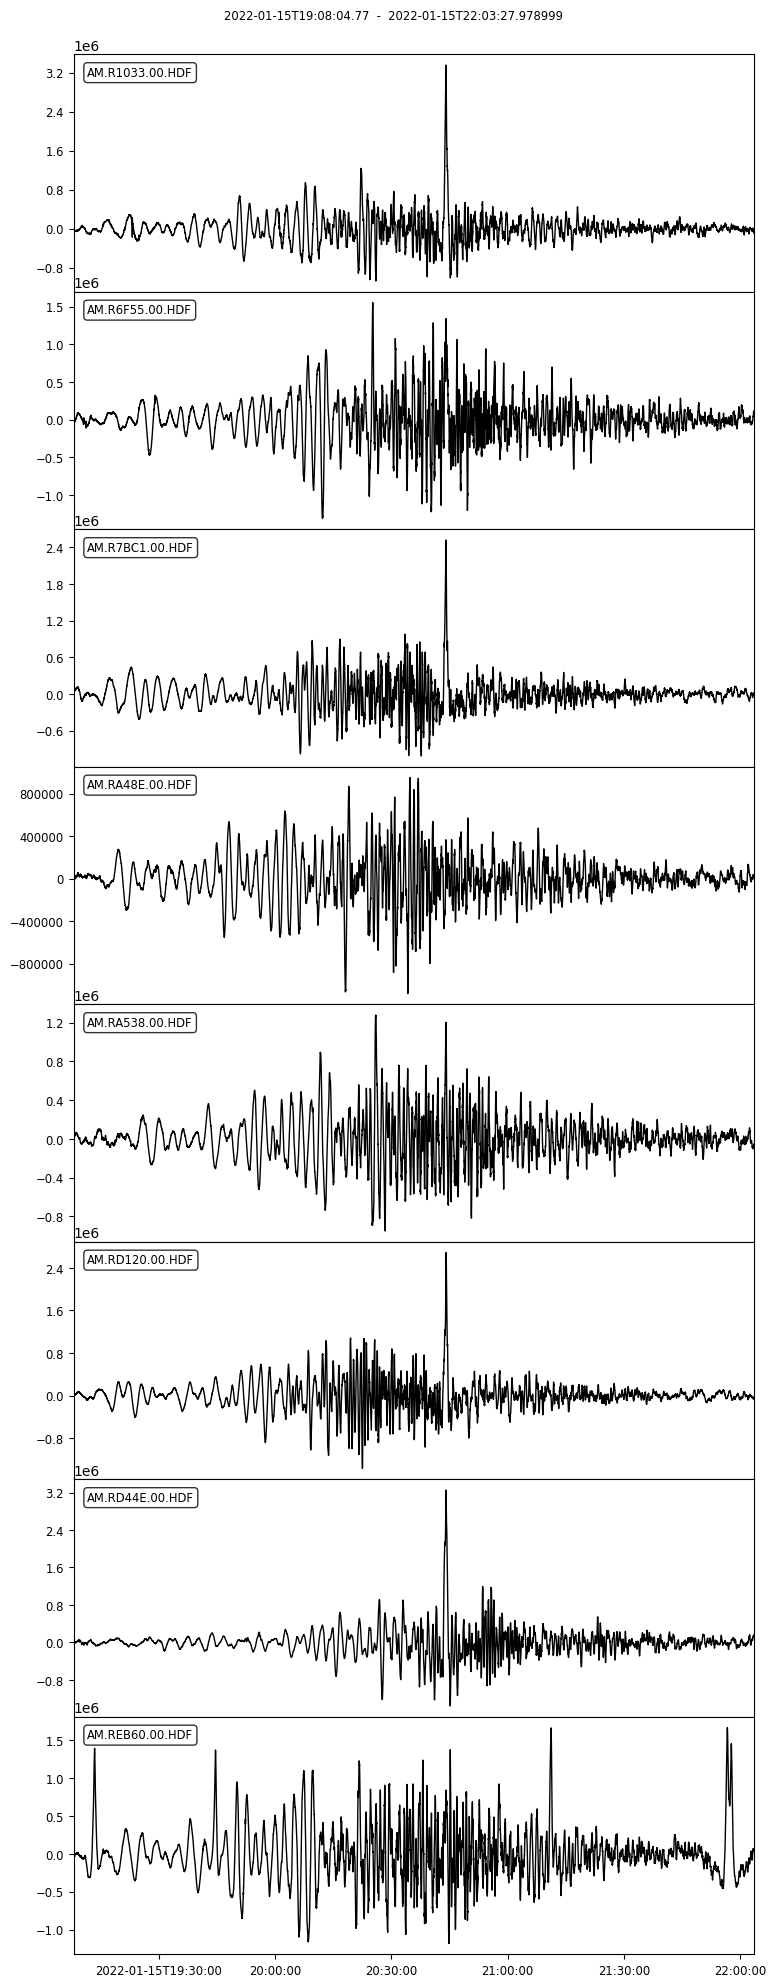

In [9]:
# Select out infrasound channels, and correct them
if straw:
    st = straw.copy()
    #st = st.select(channel='HDF') # should only have infrasound channels already due to argument in FDSN_inventory
    st.detrend('linear')
    if inv:
        inv.plot(projection='local', resolution='l')
        attach_station_coordinates_from_inventory(inv, st)
        for tr in st:
            # SCAFFOLD not removing response here, because it wasn't working anyway
            clean_trace(tr, taperFraction=0.05, filterType="bandpass", freq=[0.001, 10.0], \
                        corners=4, zerophase=True, inv=inv)

            # add coordinates
            tr.stats.distance = degrees2kilometers(locations2degrees(olat, olon, tr.stats.coordinates.latitude, tr.stats.coordinates.longitude))  
    st.plot(equal_scale=False);  

#for tr in st:
#    tr.spectrogram(log=True, wlen=500, per_lap=0.95)
# decimate to speed up
# I've seen from spectrograms that there is only weak signal above 0.1 Hz
# So let's decimate to 1 Hz, to speed up
# To decimate by factor larger than 16, have to do in multiple stages
st2 = st.copy()
for tr in st2.select(station="RA25D"):
    st2.remove(tr)
st2.filter('lowpass', freq=1.0, corners=4)
for tr in st2:
    tr.decimate(8) # samplerate now 100/8 Hz
    tr.decimate(4) # samplerate now 100/32 Hz
st2.trim(starttime=startt+5.5*3600, endtime=endt-2400)
st2.plot(equal_scale=False);


# Array analysis

In [11]:
from obspy.imaging.cm import obspy_sequential
from obspy.signal.invsim import corn_freq_2_paz
from obspy.signal.array_analysis import array_processing

#stime=obspy.UTCDateTime(2022,1,15,14,15,0)
#etime=obspy.UTCDateTime(2022,1,15,16,45,0)
stime = st2[0].stats.starttime + 1
etime = st2[0].stats.endtime - 1
max_slowness = 3.0

kwargs = dict(
    # slowness grid: X min, X max, Y min, Y max, 
    sll_x=-max_slowness, slm_x=max_slowness, sll_y=-max_slowness, slm_y=max_slowness, sl_s=0.03,
    # sliding window properties
    # win_len=1.0, win_frac=0.05, for local building collapse
    win_len=300.0, win_frac=0.1, 
    # frequency properties
    #frqlow=0.05, frqhigh=2.0, prewhiten=0,
    frqlow=0.02, frqhigh=1.0, prewhiten=0,
    # restrict output
    semb_thres=-1e9, vel_thres=-1e9,    
    stime=stime, 
    etime=etime
)

print('Starting array processing')
out = array_processing(st2, **kwargs)
print('Array processing complete')

# make output human readable, adjust backazimuth to values between 0 and 360
t, rel_power, abs_power, baz, slow = out.T
baz[baz < 0.0] += 360

Starting array processing
Array processing complete


# Results

## Time series plots

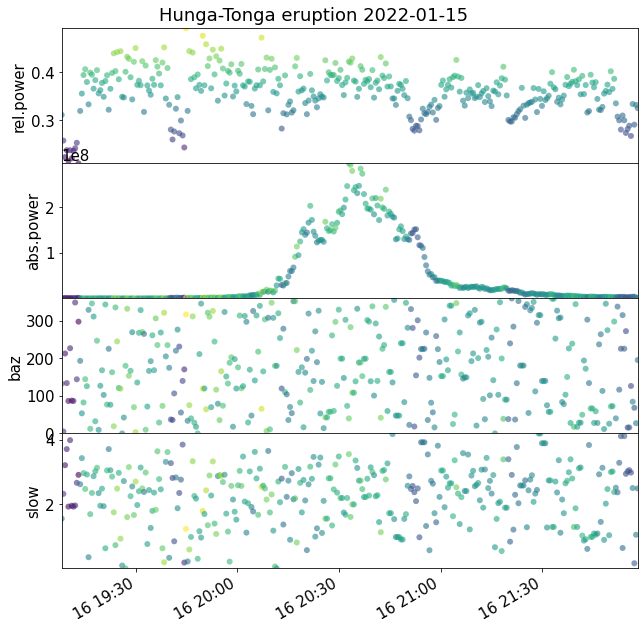

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
labels = ['rel.power', 'abs.power', 'baz', 'slow']
xlocator = mdates.AutoDateLocator()

# Plot as subplots
fig = plt.figure(figsize=(10,10))
for i, lab in enumerate(labels):
    ax = fig.add_subplot(4, 1, i + 1)
    ax.scatter(out[:, 0], out[:, i + 1], c=out[:, 1], alpha=0.6,
               edgecolors='none', cmap=obspy_sequential)
    ax.set_ylabel(lab)
    ax.set_xlim(out[0, 0], out[-1, 0])
    ax.set_ylim(out[:, i + 1].min(), out[:, i + 1].max())
    ax.xaxis.set_major_locator(xlocator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))

fig.suptitle('Hunga-Tonga eruption %s' % (
    stime.strftime('%Y-%m-%d'), ))
fig.autofmt_xdate()
fig.subplots_adjust(left=0.15, top=0.95, right=0.95, bottom=0.2, hspace=0)
plt.show()

## Rose diagram

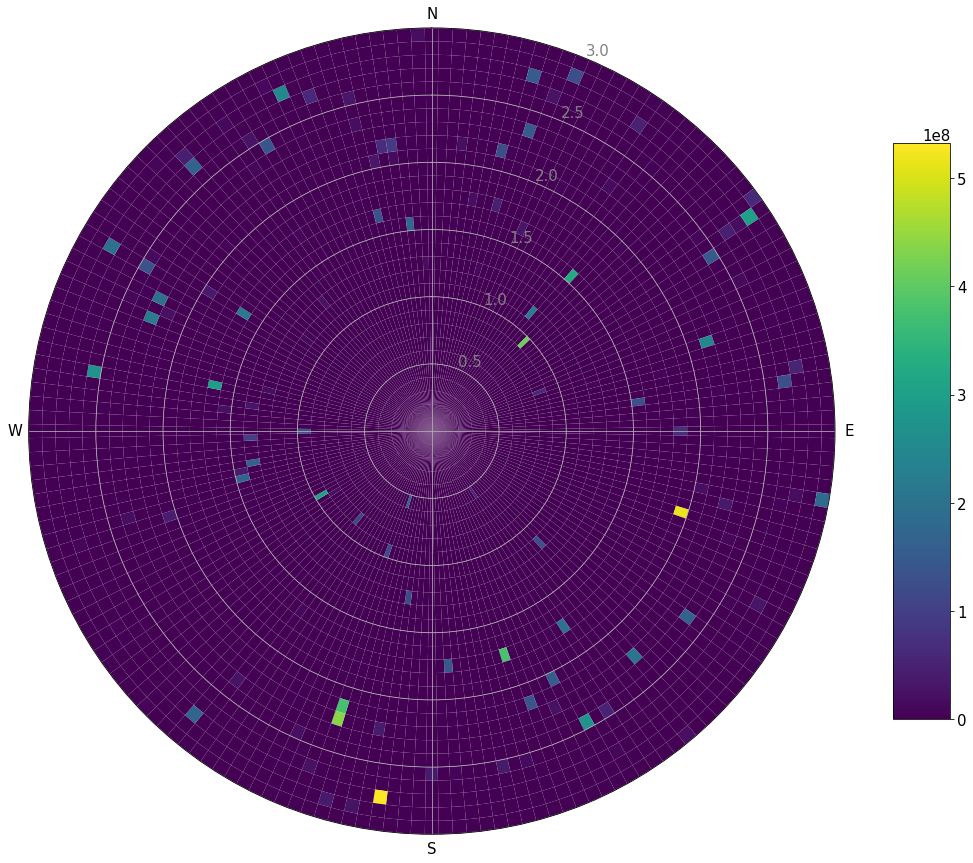

In [13]:
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
cmap = obspy_sequential

# choose number of fractions in plot (desirably 360 degree/N is an integer!)
# defaults 36, 30
N = 180
N2 = 30 
abins = np.arange(N + 1) * 360. / N # azimuth bins
sbins = np.linspace(0, 3, N2 + 1) # slowness bins

# sum rel power in bins given by abins and sbins
hist, baz_edges, sl_edges = \
    np.histogram2d(baz, slow, bins=[abins, sbins], weights=abs_power) # default is rel power

# transform to radian
baz_edges = np.radians(baz_edges)

# add polar and colorbar axes
fig = plt.figure(figsize=(16,16))
plt.rc('font', size=15)
cax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
ax = fig.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

dh = abs(sl_edges[1] - sl_edges[0])
dw = abs(baz_edges[1] - baz_edges[0])

# circle through backazimuth
for i, row in enumerate(hist):
    bars = ax.bar(x=(i * dw) * np.ones(N2),
                  height=dh * np.ones(N2),
                  width=dw, bottom=dh * np.arange(N2),
                  color=cmap(row / hist.max()))

ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
ax.set_xticklabels(['N', 'E', 'S', 'W'])

# set slowness limits
ax.set_ylim(0, max_slowness)
[i.set_color('grey') for i in ax.get_yticklabels()]
ColorbarBase(cax, cmap=cmap,
             norm=Normalize(vmin=hist.min(), vmax=hist.max()))

plt.show()

# Miscellaneous

In [ ]:
from obspy.geodetics import gps2dist_azimuth
s, az, backaz = gps2dist_azimuth(vlat, vlon, st[0].stats.coordinates.latitude, st[0].stats.coordinates.longitude)
print(s, az, backaz)

#np.arccos(2.75/3.0)*180/3.14159

In [ ]:
# For whatever reason, obspy Stream plot will not plot the corrected data (in Pascals). 
# Instead, it plots the signal in Counts still.
# So here I divide a copy of the signal by the sensitivity 56,000, so Stream plot will show Pascals.
def plot_infrasound_stream(st):
    st2 = st.copy()
    for tr in st2:
        tr.data = tr.data / 56000
    st2.plot(equal_scale=False)

## Create stack
def stack_stream(st):
    # compute travel time differences and sample delays
    r = [tr.stats.distance for tr in st]
    minr = min(r)
    v = 0.5
    for tr in st:
        tr.stats.tdiff = (tr.stats.distance - minr)/v
        tr.stats.sampledelay = np.round(tr.stats.tdiff/tr.stats.delta)    

    # align waveforms for stack, removing sample delays
    st_stack = st.copy()
    max_st = st_stack[0].stats.starttime-86400
    min_et = st_stack[0].stats.endtime
    for tr in st_stack:
        tr.stats.starttime = tr.stats.starttime - tr.stats.sampledelay * tr.stats.delta
        #print(tr.stats)
        if tr.stats.starttime > max_st:
            max_st = tr.stats.starttime    
        if tr.stats.endtime < min_et:
            min_et = tr.stats.endtime
    print(max_st, min_et)
    st_stack.trim(starttime=max_st, endtime=min_et)
    print(st_stack)

    # create the stack
    y = []
    for tr in st_stack:
        if len(y)>0:
            y += tr.data
        else:
            y = tr.data
    import matplotlib.pyplot as plt
    newtr = st_stack[0].copy()
    newtr.data = y / len(st_stack)
    newtr.stats.station='STACK'
    st_stack.append(newtr)
    st_stack.plot(equal_scale=False);


def medfilt(x, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros ((len (x), k), dtype=x.dtype)
    y[:,k2] = x
    for i in range (k2):
        j = k2 - i
        y[j:,i] = x[:-j]
        y[:j,i] = x[0]
        y[:-j,-(i+1)] = x[j:]
        y[-j:,-(i+1)] = x[-1]
    return np.median(y, axis=1)

def medfilt_stream(st, winlen_secs=10):
    for tr in st:
        tr.data = medfilt(tr.data, np.round(winlen_secs / tr.stats.delta,0) )

In [ ]:
# New Zealand data
from obspy.clients.fdsn import Client

arc_client  = 'http://service.geonet.org.nz'
# or arc_client = "GEONET"
nrt_client = 'http://service-nrt.geonet.org.nz'

t = obspy.UTCDateTime(2022,1,15,5,45,0)

#first try to get data from archive server
client = Client(arc_client)
st = client.get_waveforms('NZ', '*', '*', 'LDF', t, t + 2.5 * 3600)

print(st)

#st.plot(equal_scale=False)

for tr in st:
    inv = client.get_stations(station=tr.stats.station,level="response",
                                starttime = tr.stats.starttime,endtime = tr.stats.endtime)
    if inv:
        clean_trace(tr, taperFraction=0.05, filterType="highpass", freq=0.001, \
            corners=4, zerophase=True, inv=inv)
st.plot(equal_scale=False); 

In [17]:
traceids = ['NZ.COVZ.30.HDF', 'NZ.ETVZ.30.HDF', 'NZ.FWVZ.30.HDF', 'NZ.IVVZ.30.HDF', 'NZ.KRVZ.30.HDF', \
            'NZ.MAVZ.30.HDF', 'NZ.NEZ.30.HDF', 'NZ.NGZ.30.HDF', 'NZ.NTVZ.30.HDF', 'NZ.NTVZ.33.HDF', \
            'NZ.NTVZ.34.HDF', 'NZ.OTVZ.30.HDF', 'NZ.PREZ.31.HDF', 'NZ.PREZ.32.HDF', 'NZ.PREZ.33.HDF', \
            'NZ.SNVZ.30.HDF', 'NZ.TMVZ.30.HDF', 'NZ.TOVZ.30.HDF', 'NZ.TRVZ.30.HDF', \
            'NZ.WNVZ.30.HDF']

allst = obspy.core.Stream()
for traceid in traceids:
    net, sta, loc, chan = traceid.split('.')
    st0 = client.get_waveforms(net, sta, loc, chan, t, t + 2.5 * 3600)
    for tr in st0:
        allst.append(tr)

In [22]:
# problem is that although there is an inventory, it does not include response level info for infrasound, or coordinates
# perhaps use coordinates of HHZ channel instead

for tr in allst:
    inv = client.get_stations(station=tr.stats.station,level="response", \
        starttime = tr.stats.starttime, endtime = tr.stats.endtime)
    print(inv)
    if inv:
        attach_station_coordinates_from_inventory(inv, st)
        clean_trace(tr, taperFraction=0.05, filterType="bandpass", freq=[0.001, 10.0], \
            corners=4, zerophase=True, inv=inv)
        tr.stats.distance = degrees2kilometers(locations2degrees(olat, olon, tr.stats.coordinates.latitude, tr.stats.coordinates.longitude))  
    else:
        clean_trace(tr, taperFraction=0.05, filterType="bandpass", freq=[0.001, 10.0], \
            corners=4, zerophase=True)        
allst.plot(equal_scale=False); 
 

Inventory created at 2022-02-01T00:56:13.000000Z
	Created by: Delta
		    
	Sending institution: GeoNet (WEL(GNS_Test))
	Contains:
		Networks (1):
			NZ
		Stations (1):
			NZ.COVZ (Chateau Observatory)
		Channels (8):
			NZ.COVZ.10.HHZ, NZ.COVZ.10.HH1, NZ.COVZ.10.HH2, NZ.COVZ.10.LHZ, 
			NZ.COVZ.10.LH1, NZ.COVZ.10.LH2, NZ.COVZ.30.HDF, NZ.COVZ.30.LDF
No matching response info found for NZ.COVZ.30.HDF


AttributeError: coordinates

In [19]:
from obspy.imaging.cm import obspy_sequential
from obspy.signal.invsim import corn_freq_2_paz
from obspy.signal.array_analysis import array_processing
def array_analysis(st):
    #stime=obspy.UTCDateTime(2022,1,15,14,15,0)
    #etime=obspy.UTCDateTime(2022,1,15,16,45,0)
    stime = st[0].stats.starttime + 1
    etime = st[0].stats.endtime - 1
    max_slowness = 3.0

    kwargs = dict(
        # slowness grid: X min, X max, Y min, Y max, 
        sll_x=-max_slowness, slm_x=max_slowness, sll_y=-max_slowness, slm_y=max_slowness, sl_s=0.03,
        # sliding window properties
        # win_len=1.0, win_frac=0.05, for local building collapse
        win_len=300.0, win_frac=0.1, 
        # frequency properties
        #frqlow=0.05, frqhigh=2.0, prewhiten=0,
        frqlow=0.02, frqhigh=1.0, prewhiten=0,
        # restrict output
        semb_thres=-1e9, vel_thres=-1e9,    
        stime=stime, 
        etime=etime
    )

    print('Starting array processing')
    out = array_processing(st, **kwargs)
    print('Array processing complete')
    return out


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
def array_results_plot_timeseries(t, rel_power, abs_power, baz, slow):
    labels = ['rel.power', 'abs.power', 'baz', 'slow']
    xlocator = mdates.AutoDateLocator()

    # Plot as subplots
    fig = plt.figure(figsize=(10,10))
    for i, lab in enumerate(labels):
        ax = fig.add_subplot(4, 1, i + 1)
        ax.scatter(out[:, 0], out[:, i + 1], c=out[:, 1], alpha=0.6,
                   edgecolors='none', cmap=obspy_sequential)
        ax.set_ylabel(lab)
        ax.set_xlim(out[0, 0], out[-1, 0])
        ax.set_ylim(out[:, i + 1].min(), out[:, i + 1].max())
        ax.xaxis.set_major_locator(xlocator)
        ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))

    fig.suptitle('Hunga-Tonga eruption %s' % (
        stime.strftime('%Y-%m-%d'), ))
    fig.autofmt_xdate()
    fig.subplots_adjust(left=0.15, top=0.95, right=0.95, bottom=0.2, hspace=0)
    plt.show()
    
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
def array_results_plot_rose(t, rel_power, abs_power, baz, slow):
    cmap = obspy_sequential

    # choose number of fractions in plot (desirably 360 degree/N is an integer!)
    # defaults 36, 30
    N = 180
    N2 = 30 
    abins = np.arange(N + 1) * 360. / N # azimuth bins
    sbins = np.linspace(0, 3, N2 + 1) # slowness bins

    # sum rel power in bins given by abins and sbins
    hist, baz_edges, sl_edges = \
        np.histogram2d(baz, slow, bins=[abins, sbins], weights=abs_power) # default is rel power

    # transform to radian
    baz_edges = np.radians(baz_edges)

    # add polar and colorbar axes
    fig = plt.figure(figsize=(16,16))
    plt.rc('font', size=15)
    cax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
    ax = fig.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("N")

    dh = abs(sl_edges[1] - sl_edges[0])
    dw = abs(baz_edges[1] - baz_edges[0])

    # circle through backazimuth
    for i, row in enumerate(hist):
        bars = ax.bar(x=(i * dw) * np.ones(N2),
                      height=dh * np.ones(N2),
                      width=dw, bottom=dh * np.arange(N2),
                      color=cmap(row / hist.max()))

    ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
    ax.set_xticklabels(['N', 'E', 'S', 'W'])

    # set slowness limits
    ax.set_ylim(0, max_slowness)
    [i.set_color('grey') for i in ax.get_yticklabels()]
    ColorbarBase(cax, cmap=cmap,
                 norm=Normalize(vmin=hist.min(), vmax=hist.max()))

    plt.show()
    
# make output human readable, adjust backazimuth to values between 0 and 360
out = array_analysis(allst)
t, rel_power, abs_power, baz, slow = out.T
baz[baz < 0.0] += 360
array_results_plot_timeseries(t, rel_power, abs_power, baz, slow)
array_results_plot_rose(t, rel_power, abs_power, baz, slow)

Starting array processing


AttributeError: coordinates